In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import geopandas as gpd
import requests
from shapely.geometry import box

from odc.stac import configure_rio, stac_load
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/laserglaciers/miniconda3/envs/py310v2/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40853 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40853/status,
Dashboard: http://127.0.0.1:40853/status,Workers: 4
Total threads: 12,Total memory: 15.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44891,Workers: 4
Dashboard: http://127.0.0.1:40853/status,Total threads: 12
Started: Just now,Total memory: 15.45 GiB
Comm: tcp://127.0.0.1:43131,Total threads: 3
Dashboard: http://127.0.0.1:36233/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:34451,


2024-09-27 22:45:10,686 - distributed.scheduler - WARNING - Worker failed to heartbeat for 316s; attempting restart: <WorkerState 'tcp://127.0.0.1:37557', name: 2, status: running, memory: 0, processing: 0>


In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=pc.sign_inplace)
jkb_mel = gpd.read_file('/media/laserglaciers/upernavik/iceberg_py/geoms/jkb/melange_poly_box_4326.gpkg')
minx, miny, maxx, maxy = jkb_mel.geometry.total_bounds
kbox = box(minx, miny, maxx, maxy)

query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = "2020-08",
    query = {"s2:mgrs_tile": dict(eq="22WEB"),
        "eo:cloud_cover": {"lt": 10}})

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 11 datasets


In [4]:
resolution = 10
SHRINK = 1
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=jkb_mel
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir


<xarray.Dataset> Size: 1GB
Dimensions:      (y: 2807, x: 5996, time: 11)
Coordinates:
  * y            (y) float64 22kB 7.687e+06 7.687e+06 ... 7.659e+06 7.659e+06
  * x            (x) float64 48kB 4.994e+05 4.994e+05 ... 5.594e+05 5.594e+05
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 88B 2020-08-02T15:29:11.024000 ... 202...
Data variables:
    red          (time, y, x) uint16 370MB dask.array<chunksize=(1, 2807, 5996), meta=np.ndarray>
    green        (time, y, x) uint16 370MB dask.array<chunksize=(1, 2807, 5996), meta=np.ndarray>
    blue         (time, y, x) uint16 370MB dask.array<chunksize=(1, 2807, 5996), meta=np.ndarray>
    nir          (time, y, x) uint16 370MB dask.array<chunksize=(1, 2807, 5996), meta=np.ndarray>

In [5]:
def stac_query(date):
    query = catalog.search(
    collections = ["sentinel-2-l2a"],
    datetime = date,
    query = {"s2:mgrs_tile": dict(eq="22WEB"),
        "eo:cloud_cover": {"lt": 10}})

    items = list(query.items())
    print(f"Found: {len(items):d} datasets")

    return items

def stac_load_help(items):
    xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue", "nir"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=jkb_mel
    )

    return xx

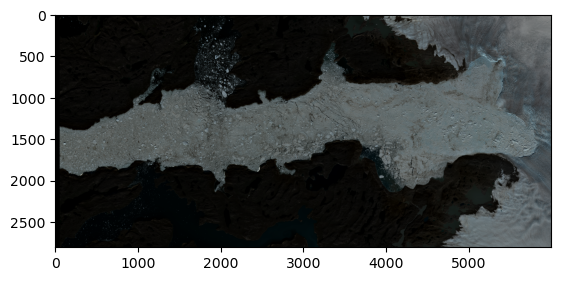

In [6]:
time=2
rgb = np.dstack((xx.red.isel(time=time).values,
                 xx.green.isel(time=time).values,
                 xx.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# Display the normalized RGB image using plt.imshow
plt.imshow(rgb_norm)

In [7]:
time=2
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

def plot_rbg(time, image_stac):
    rgb = np.dstack((image_stac.red.isel(time=time).values,
                     image_stac.green.isel(time=time).values,
                     image_stac.blue.isel(time=time).values))
    # Normalize the RGB data
    rgb_norm = rgb / np.nanmax(rgb)
    
    # Display the normalized RGB image using plt.imshow
    plt.imshow(rgb_norm)
    
def plot_rbg_rasterio(time, image_stac):
    rgb = np.dstack((image_stac.red.isel(time=time).values,
                     image_stac.green.isel(time=time).values,
                     image_stac.blue.isel(time=time).values))
    # Normalize the RGB data
    rgb_raster = reshape_as_raster(rgb)
    affine = image_stac.odc.affine
    show(rgb_raster, transform=affine, adjust=True)



In [8]:
items[-3]
items2keep = []

In [9]:
items2keep.append(items[-3])
items2keep

[<Item id=S2A_MSIL2A_20200816T150921_R025_T22WEB_20200818T132535>]

In [10]:
items2 = stac_query("2019-10")
cube_1903 = stac_load_help(items2)
cube_1903.odc.affine

Found: 8 datasets


Affine(10.0, 0.0, 499410.0,
       0.0, -10.0, 7687150.0)

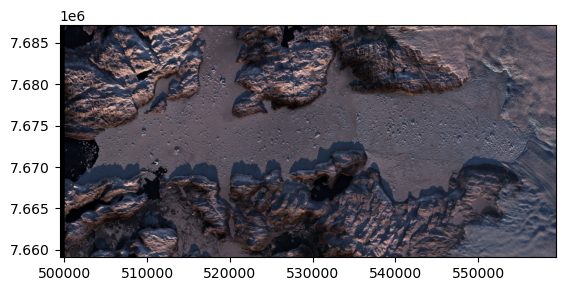

In [11]:
plot_rbg_rasterio(-1, cube_1903)

In [12]:
items2

[<Item id=S2B_MSIL2A_20191029T152249_R068_T22WEB_20201004T072856>,
 <Item id=S2A_MSIL2A_20191028T150331_R125_T22WEB_20201004T070000>,
 <Item id=S2B_MSIL2A_20191026T151229_R025_T22WEB_20201004T063038>,
 <Item id=S2A_MSIL2A_20191014T152211_R068_T22WEB_20201004T021115>,
 <Item id=S2B_MSIL2A_20191013T150149_R125_T22WEB_20201004T015921>,
 <Item id=S2B_MSIL2A_20191009T152129_R068_T22WEB_20201004T003051>,
 <Item id=S2A_MSIL2A_20191008T150121_R125_T22WEB_20201003T235725>,
 <Item id=S2A_MSIL2A_20191004T152101_R068_T22WEB_20201003T222743>]

In [13]:
items2keep.append(items2[0])

In [14]:
items2keep

[<Item id=S2A_MSIL2A_20200816T150921_R025_T22WEB_20200818T132535>,
 <Item id=S2B_MSIL2A_20191029T152249_R068_T22WEB_20201004T072856>]

In [15]:
def stac_query_l8(date):
    query = catalog.search(
    collections = ["landsat-c2-l2"],
    datetime = date,
    query = {"eo:cloud_cover": {"lt": 10}},
    bbox = jkb_mel.geometry.total_bounds
    )

    items = list(query.items())
    print(f"Found: {len(items):d} datasets")

    return items


def stac_load_help_l8(items):
    xx = stac_load(
    items,
    chunks={},
    bands=["red", "green", "blue"],
    patch_url=pc.sign,
    resolution=30,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=jkb_mel
    )

    return xx

In [16]:
items3 = stac_query_l8("2001-07")
cube_1007 = stac_load_help_l8(items2)

Found: 5 datasets


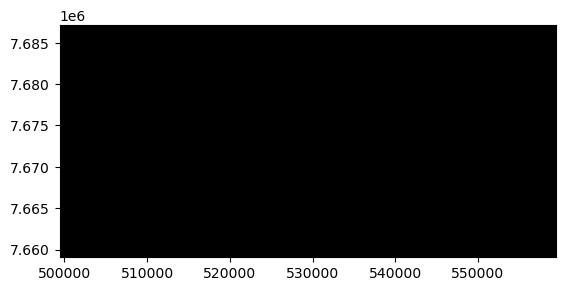

In [17]:
plot_rbg_rasterio(1, cube_1007)

In [18]:
cube_1007

<xarray.Dataset> Size: 90MB
Dimensions:      (y: 937, x: 1999, time: 8)
Coordinates:
  * y            (y) float64 7kB 7.687e+06 7.687e+06 ... 7.659e+06 7.659e+06
  * x            (x) float64 16kB 4.994e+05 4.995e+05 ... 5.593e+05 5.594e+05
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 64B 2019-10-04T15:21:01.024000 ... 201...
Data variables:
    red          (time, y, x) uint16 30MB dask.array<chunksize=(1, 937, 1999), meta=np.ndarray>
    green        (time, y, x) uint16 30MB dask.array<chunksize=(1, 937, 1999), meta=np.ndarray>
    blue         (time, y, x) uint16 30MB dask.array<chunksize=(1, 937, 1999), meta=np.ndarray>

In [19]:
items3[-1]

<Item id=LE07_L2SP_009011_20010707_02_T1>

In [20]:
items2keep.append(items3[-1])

In [21]:
items2keep

[<Item id=S2A_MSIL2A_20200816T150921_R025_T22WEB_20200818T132535>,
 <Item id=S2B_MSIL2A_20191029T152249_R068_T22WEB_20201004T072856>,
 <Item id=LE07_L2SP_009011_20010707_02_T1>]

In [22]:
items4 = stac_query_l8("1990-06")
cube_9506 = stac_load_help_l8(items4)

Found: 4 datasets


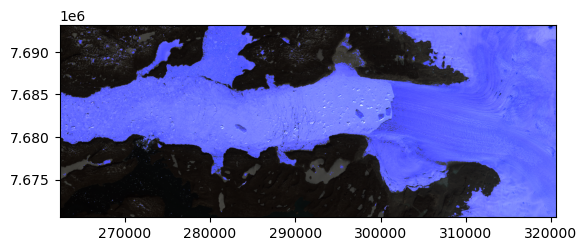

In [23]:
plot_rbg_rasterio(1, cube_9506)

In [24]:
cube_9506.time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array(['1990-06-08T14:14:36.498056000', '1990-06-15T14:20:45.657000000',
       '1990-06-22T14:26:57.087038000', '1990-06-24T14:14:35.554050000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32623
  * time         (time) datetime64[ns] 32B 1990-06-08T14:14:36.498056 ... 199...

In [25]:
items4

[<Item id=LT05_L2SP_008011_19900624_02_T1>,
 <Item id=LT05_L2SP_010011_19900622_02_T1>,
 <Item id=LT05_L2SP_009011_19900615_02_T1>,
 <Item id=LT05_L2SP_008011_19900608_02_T1>]

In [26]:
items2keep.append(items4[-2])
items2keep

[<Item id=S2A_MSIL2A_20200816T150921_R025_T22WEB_20200818T132535>,
 <Item id=S2B_MSIL2A_20191029T152249_R068_T22WEB_20201004T072856>,
 <Item id=LE07_L2SP_009011_20010707_02_T1>,
 <Item id=LT05_L2SP_009011_19900615_02_T1>]

In [27]:
items5 = stac_query_l8("2015-08")
cube_1508 = stac_load_help_l8(items5)

Found: 3 datasets


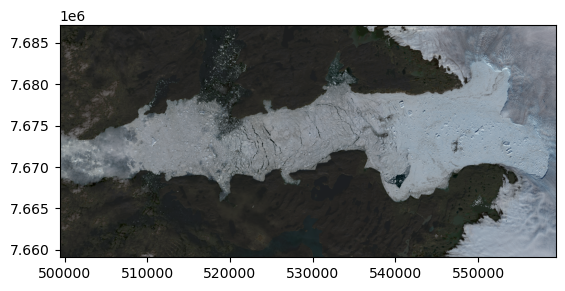

In [28]:
plot_rbg_rasterio(1, cube_1508)

In [29]:
cube_1508.time

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2015-08-16T14:54:09.164144000', '2015-08-23T15:00:22.974066000',
       '2015-08-25T14:48:25.899683000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 24B 2015-08-16T14:54:09.164144 ... 201...

In [30]:
items5

[<Item id=LC08_L2SP_007012_20150825_02_T1>,
 <Item id=LC08_L2SP_009011_20150823_02_T1>,
 <Item id=LC08_L2SP_008011_20150816_02_T1>]

In [31]:
items2keep.append(items5[1])
items2keep

[<Item id=S2A_MSIL2A_20200816T150921_R025_T22WEB_20200818T132535>,
 <Item id=S2B_MSIL2A_20191029T152249_R068_T22WEB_20201004T072856>,
 <Item id=LE07_L2SP_009011_20010707_02_T1>,
 <Item id=LT05_L2SP_009011_19900615_02_T1>,
 <Item id=LC08_L2SP_009011_20150823_02_T1>]

In [32]:
import pickle

with open('jkb_image_item_list.pkl', 'wb') as f:
    pickle.dump(items2keep, f)

In [34]:
jkb_stac = stac_load(
    items2keep,
    chunks={},
    bands=["red", "green", "blue"],
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=jkb_mel
)


In [35]:
jkb_stac

<xarray.Dataset> Size: 505MB
Dimensions:      (y: 2808, x: 5996, time: 5)
Coordinates:
  * y            (y) float64 22kB 7.687e+06 7.687e+06 ... 7.659e+06 7.659e+06
  * x            (x) float64 48kB 4.994e+05 4.994e+05 ... 5.594e+05 5.594e+05
    spatial_ref  int32 4B 32622
  * time         (time) datetime64[ns] 40B 1990-06-15T14:20:45.657000 ... 202...
Data variables:
    red          (time, y, x) uint16 168MB dask.array<chunksize=(1, 2808, 5996), meta=np.ndarray>
    green        (time, y, x) uint16 168MB dask.array<chunksize=(1, 2808, 5996), meta=np.ndarray>
    blue         (time, y, x) uint16 168MB dask.array<chunksize=(1, 2808, 5996), meta=np.ndarray>

In [36]:
jkb_stac.to_netcdf('jkb_netcdf.nc')